# Setup for TensorFlow on TPU or CPU/GPU
### Import necessary libraries
### Check TPU or CPU/GPU available


In [1]:
import tensorflow as tf
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, classification_report
from tqdm import tqdm
import os
import cv2

try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()  
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.TPUStrategy(tpu) 
    print("Running on TPU")
except ValueError:
    strategy = tf.distribute.get_strategy() 
    print("Running on CPU/GPU")

print("Number of accelerators:", strategy.num_replicas_in_sync)

E0000 00:00:1733690247.528153      13 common_lib.cc:798] Could not set metric server port: INVALID_ARGUMENT: Could not find SliceBuilder port 8471 in any of the 0 ports provided in `tpu_process_addresses`="local"
=== Source Location Trace: ===
learning/45eac/tfrc/runtime/common_lib.cc:479
D1208 20:37:27.536792559      13 config.cc:196]                        gRPC EXPERIMENT call_status_override_on_cancellation   OFF (default:OFF)
D1208 20:37:27.536807257      13 config.cc:196]                        gRPC EXPERIMENT call_v3                                OFF (default:OFF)
D1208 20:37:27.536811049      13 config.cc:196]                        gRPC EXPERIMENT canary_client_privacy                  ON  (default:ON)
D1208 20:37:27.536813860      13 config.cc:196]                        gRPC EXPERIMENT capture_base_context                   ON  (default:ON)
D1208 20:37:27.536816742      13 config.cc:196]                        gRPC EXPERIMENT client_idleness                        ON  (defau

INFO:tensorflow:Deallocate tpu buffers before initializing tpu system.
INFO:tensorflow:Initializing the TPU system: local


I0000 00:00:1733690261.754551      13 service.cc:145] XLA service 0x56a840d54380 initialized for platform TPU (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1733690261.754598      13 service.cc:153]   StreamExecutor device (0): TPU, 2a886c8
I0000 00:00:1733690261.754603      13 service.cc:153]   StreamExecutor device (1): TPU, 2a886c8
I0000 00:00:1733690261.754608      13 service.cc:153]   StreamExecutor device (2): TPU, 2a886c8
I0000 00:00:1733690261.754611      13 service.cc:153]   StreamExecutor device (3): TPU, 2a886c8
I0000 00:00:1733690261.754613      13 service.cc:153]   StreamExecutor device (4): TPU, 2a886c8
I0000 00:00:1733690261.754616      13 service.cc:153]   StreamExecutor device (5): TPU, 2a886c8
I0000 00:00:1733690261.754619      13 service.cc:153]   StreamExecutor device (6): TPU, 2a886c8
I0000 00:00:1733690261.754621      13 service.cc:153]   StreamExecutor device (7): TPU, 2a886c8


INFO:tensorflow:Finished initializing TPU system.
INFO:tensorflow:Found TPU system:
INFO:tensorflow:*** Num TPU Cores: 8
INFO:tensorflow:*** Num TPU Workers: 1
INFO:tensorflow:*** Num TPU Cores Per Worker: 8
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:0, TPU, 0, 0)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:1, TPU, 0, 0)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:2, TPU, 0, 0)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:3, TPU, 0, 0)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:4, TPU, 0, 0)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:5, TPU, 0, 0)
I

# Data Preprocessing for Illinois DOC Labeled Faces Dataset
### Load CSV Data
### Keep necessary cols
### add front and side image paths

In [3]:

csv_path = '/kaggle/input/illinois-doc-labeled-faces-dataset/person.csv'
data = pd.read_csv(csv_path, sep=';')

data = data[['id', 'sex', 'height', 'weight']]
data['Gender'] = data['sex'].apply(lambda x: 1 if str(x).strip().lower() == 'male' else 0)
data['front_image'] = data['id'].apply(lambda x: os.path.join('/kaggle/input/illinois-doc-labeled-faces-dataset/front/front', f'{x}.jpg'))
data['side_image'] = data['id'].apply(lambda x: os.path.join('/kaggle/input/illinois-doc-labeled-faces-dataset/side/side', f'{x}.jpg'))

In [4]:
data.shape

(61110, 7)

# Image Preprocessing and Feature Extraction
### Define `load_and_preprocess_image` Function
#### Resize image to 128x128
#### convert to grayscale
#### Flatten image

### Store processed data 

In [5]:
def load_and_preprocess_image(image_path):
    image = cv2.imread(image_path)
    if image is None:
        return None
    image_resized = cv2.resize(image, (128, 128))
    image_gray = cv2.cvtColor(image_resized, cv2.COLOR_BGR2GRAY)
    return image_gray.flatten()

tqdm.pandas(desc="Processing front images")
data['front_features'] = data['front_image'].progress_apply(load_and_preprocess_image)

tqdm.pandas(desc="Processing side images")
data['side_features'] = data['side_image'].progress_apply(load_and_preprocess_image)

Processing side images: 100%|██████████| 61110/61110 [11:48<00:00, 86.26it/s] 


## 1. Feature Combination
- **Data Cleaning**: We begin by removing rows with missing values in either the `front_features` or `side_features` columns.
- **Feature Engineering**: After cleaning, we concatenate `front_features` and `side_features` into a new feature, `combined_features`. This helps create a single vector of features for further analysis.

## 2. Cleaning & Gender-based Data Sampling

- **Data Cleaning**: The initial step involves cleaning the dataset by removing rows where either `front_features` or `side_features` is missing.
- **Feature Engineering**: After cleaning, the `front_features` and `side_features` are combined into a new `combined_features` column for further analysis.
- **Balancing the Data**: To address potential bias in machine learning models, the data is balanced by gender. Equal numbers of entries are sampled for both men and women, ensuring the model receives an unbiased representation of both groups.



In [8]:
data = data.dropna(subset=['front_features', 'side_features'])
data['combined_features'] = data.apply(
    lambda row: np.concatenate((row['front_features'], row['side_features'])), axis=1
)

men_data = data[data['Gender'] == 1]
women_data = data[data['Gender'] == 0]
men_sampled = men_data.sample(n=15000, random_state=42)
women_sampled = women_data.sample(n=15000, random_state=42, replace=True)
balanced_data = pd.concat([men_sampled, women_sampled]).reset_index(drop=True)

In [9]:
data.shape

(60141, 10)

# Prepare Data for Training

### Explanation:
1. **Prepare the Features (`X`) and Labels (`y`)**:
    - The `combined_features` are extracted from the `balanced_data` and converted into a NumPy array using `np.array()`. This forms the feature matrix `X`.
    - The target variable (`Gender`) is stored in the `y` variable as a NumPy array.

2. **Normalize the Features**:
    - To standardize the feature values, the `StandardScaler` from `sklearn.preprocessing` is used. This scales the features to have zero mean and unit variance, which is essential for many machine learning algorithms.
    - The `fit_transform()` method is applied to `X`, which computes the scaling parameters (mean and standard deviation) and applies the transformation.


In [10]:
# Prepare data for training
X = np.array(balanced_data['combined_features'].tolist())
y = balanced_data['Gender'].values

# Normalize features
scaler = StandardScaler()
X = scaler.fit_transform(X)

# Model Training and Evaluation on TPU

### Explanation:
1. **Data Splitting**:
    - The dataset is split into training and testing sets using `train_test_split()` from `sklearn.model_selection`. 
    - 20% of the data is reserved for testing (`test_size=0.2`)

2. **Creating TensorFlow Datasets**:
    - The `train_dataset` and `test_dataset` are created using `tf.data.Dataset.from_tensor_slices()`, which converts the NumPy arrays `X_train`, `y_train`, `X_test`, and `y_test` into TensorFlow datasets.
    - The datasets are then batched in size 1024 and optimized for performance using `.prefetch(tf.data.AUTOTUNE)` to prefetch data during training.

3. **Model Construction**:
    - A simple neural network model is created using `tf.keras.Sequential()`. The model consists of an input layer (matching the feature shape) followed by a dense layer with one output unit and a sigmoid activation function (since this is a binary classification problem).
    - The model is compiled with the `Adam` optimizer, binary cross-entropy loss, and accuracy as the evaluation metric.

4. **Training the Model**:
    - The model is trained using the `fit()` method on the `train_dataset`, with the `test_dataset` used for validation. The model is trained for 10 epochs.

5. **Evaluating the Model**:
    - After training, the model is evaluated on the test set using the `evaluate()` method to obtain the test accuracy.

6. **Making Predictions**:
    - Predictions are made on the test set using `model.predict()`. The predicted values are thresholded to classify the labels (greater than 0.5 as `1` and otherwise as `0`).
    - The accuracy of the predictions is computed using `accuracy_score` from `sklearn.metrics`, and a detailed classification report is generated using `classification_report`.


In [11]:

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

train_dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train)).batch(1024).prefetch(tf.data.AUTOTUNE)
test_dataset = tf.data.Dataset.from_tensor_slices((X_test, y_test)).batch(1024).prefetch(tf.data.AUTOTUNE)

with strategy.scope():
    model = tf.keras.Sequential([
        tf.keras.layers.Input(shape=(X_train.shape[1],)),
        tf.keras.layers.Dense(1, activation='sigmoid')
    ])
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

print("Training model on TPU...")
history = model.fit(train_dataset, validation_data=test_dataset, epochs=10)

print("Evaluating model...")
results = model.evaluate(test_dataset)
print(f"Test Accuracy: {results[1]:.4f}")

y_pred = (model.predict(X_test) > 0.5).astype("int32").flatten()
accuracy = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred)

print("Classification Report:")
print(report)

I0000 00:00:1733691870.936985      13 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


Training model on TPU...
Epoch 1/10


2024-12-08 21:04:52.586419: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node StatefulPartitionedCall.
I0000 00:00:1733691893.267069     835 tpu_compilation_cache_interface.cc:441] TPU host compilation cache miss: cache_key(b9f3403b48c486d:0:0), session_name()


 1/24 ━━━━━━━━━━━━━━━━━━━━ 2:55 8s/step - accuracy: 0.5234 - loss: 0.8702

I0000 00:00:1733691893.802071     835 tpu_compile_op_common.cc:245] Compilation of b9f3403b48c486d:0:0 with session name  took 534.932285ms and succeeded
I0000 00:00:1733691893.805800     835 tpu_compilation_cache_interface.cc:475] TPU host compilation cache: compilation complete for cache_key(b9f3403b48c486d:0:0), session_name(), subgraph_key(std::string(property.function_name) = "cluster_one_step_on_iterator_4408205059983670217", property.function_library_fingerprint = 9267957973823279421, property.mlir_module_fingerprint = 0, property.num_replicas = 8, topology.chip_bounds().x = 2, topology.chip_bounds().y = 2, topology.chip_bounds().z = 1, topology.wrap().x = false, topology.wrap().y = false, topology.wrap().z = false, std::string(property.shapes_prefix) = "128,32768,;128,;", property.guaranteed_constants_size = 0, embedding_partitions_fingerprint = "1688352644216761960")
I0000 00:00:1733691893.805833     835 tpu_compilation_cache_interface.cc:541] After adding entry for key b9f340

23/24 ━━━━━━━━━━━━━━━━━━━━ 0s 363ms/step - accuracy: 0.7289 - loss: 1.2333

I0000 00:00:1733691901.876470     806 tpu_compilation_cache_interface.cc:441] TPU host compilation cache miss: cache_key(52afde8eed80c752:0:0), session_name()


24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 366ms/step - accuracy: 0.7324 - loss: 1.2204

I0000 00:00:1733691902.229782     806 tpu_compile_op_common.cc:245] Compilation of 52afde8eed80c752:0:0 with session name  took 353.261536ms and succeeded
I0000 00:00:1733691902.231767     806 tpu_compilation_cache_interface.cc:475] TPU host compilation cache: compilation complete for cache_key(52afde8eed80c752:0:0), session_name(), subgraph_key(std::string(property.function_name) = "cluster_one_step_on_iterator_4408205059983670217", property.function_library_fingerprint = 9267957973823279421, property.mlir_module_fingerprint = 0, property.num_replicas = 8, topology.chip_bounds().x = 2, topology.chip_bounds().y = 2, topology.chip_bounds().z = 1, topology.wrap().x = false, topology.wrap().y = false, topology.wrap().z = false, std::string(property.shapes_prefix) = "56,32768,;56,;", property.guaranteed_constants_size = 0, embedding_partitions_fingerprint = "1688352644216761960")
I0000 00:00:1733691902.231791     806 tpu_compilation_cache_interface.cc:541] After adding entry for key 52afde

24/24 ━━━━━━━━━━━━━━━━━━━━ 26s 802ms/step - accuracy: 0.7357 - loss: 1.2085 - val_accuracy: 0.8907 - val_loss: 0.3772
Epoch 2/10


I0000 00:00:1733691912.228620     768 tpu_compile_op_common.cc:245] Compilation of 7689df310ebb0070:0:0 with session name  took 206.668312ms and succeeded
I0000 00:00:1733691912.229806     768 tpu_compilation_cache_interface.cc:475] TPU host compilation cache: compilation complete for cache_key(7689df310ebb0070:0:0), session_name(), subgraph_key(std::string(property.function_name) = "cluster_one_step_on_iterator_4976483026312115192", property.function_library_fingerprint = 2801862747699644202, property.mlir_module_fingerprint = 0, property.num_replicas = 8, topology.chip_bounds().x = 2, topology.chip_bounds().y = 2, topology.chip_bounds().z = 1, topology.wrap().x = false, topology.wrap().y = false, topology.wrap().z = false, std::string(property.shapes_prefix) = "110,32768,;110,;", property.guaranteed_constants_size = 0, embedding_partitions_fingerprint = "1688352644216761960")
I0000 00:00:1733691912.229827     768 tpu_compilation_cache_interface.cc:541] After adding entry for key 7689

24/24 ━━━━━━━━━━━━━━━━━━━━ 22s 664ms/step - accuracy: 0.8743 - loss: 0.4314 - val_accuracy: 0.9187 - val_loss: 0.2245
Epoch 3/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 22s 664ms/step - accuracy: 0.9002 - loss: 0.2738 - val_accuracy: 0.9360 - val_loss: 0.1665
Epoch 4/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 21s 648ms/step - accuracy: 0.9323 - loss: 0.2005 - val_accuracy: 0.9387 - val_loss: 0.1543
Epoch 5/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 21s 648ms/step - accuracy: 0.9410 - loss: 0.1685 - val_accuracy: 0.9427 - val_loss: 0.1463
Epoch 6/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 21s 632ms/step - accuracy: 0.9478 - loss: 0.1533 - val_accuracy: 0.9480 - val_loss: 0.1382
Epoch 7/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 21s 638ms/step - accuracy: 0.9541 - loss: 0.1400 - val_accuracy: 0.9520 - val_loss: 0.1297
Epoch 8/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 21s 633ms/step - accuracy: 0.9613 - loss: 0.1291 - val_accuracy: 0.9520 - val_loss: 0.1242
Epoch 9/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 21s 631ms/step - accuracy: 0.9631 - loss: 0.1191 - val_accuracy: 0.954

2024-12-08 21:08:33.497837: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node sequential_1/dense_1/Add/ReadVariableOp.
I0000 00:00:1733692113.517542     807 tpu_compilation_cache_interface.cc:441] TPU host compilation cache miss: cache_key(139becd6541f1611:0:0), session_name()
I0000 00:00:1733692113.627818     807 tpu_compile_op_common.cc:245] Compilation of 139becd6541f1611:0:0 with session name  took 110.213099ms and succeeded
I0000 00:00:1733692113.628155     807 tpu_compilation_cache_interface.cc:475] TPU host compilation cache: compilation complete for cache_key(139becd6541f1611:0:0), session_name(), subgraph_key(std::string(property.function_name) = "cluster_one_step_on_data_distributed_14510903002799379623", property.function_library_fingerprint = 15930706575624744263, property.mlir_module_fingerprint = 0, property.num_replicas = 8, topology.chip_bounds().x = 2, topology.chip_bounds().y = 2, t

188/188 ━━━━━━━━━━━━━━━━━━━━ 7s 36ms/step


I0000 00:00:1733692120.172780     744 tpu_compilation_cache_interface.cc:441] TPU host compilation cache miss: cache_key(ab172d2641ead720:0:0), session_name()
I0000 00:00:1733692120.297106     744 tpu_compile_op_common.cc:245] Compilation of ab172d2641ead720:0:0 with session name  took 124.280991ms and succeeded
I0000 00:00:1733692120.297433     744 tpu_compilation_cache_interface.cc:475] TPU host compilation cache: compilation complete for cache_key(ab172d2641ead720:0:0), session_name(), subgraph_key(std::string(property.function_name) = "cluster_one_step_on_data_distributed_14220226870953011906", property.function_library_fingerprint = 17805353801197990262, property.mlir_module_fingerprint = 0, property.num_replicas = 8, topology.chip_bounds().x = 2, topology.chip_bounds().y = 2, topology.chip_bounds().z = 1, topology.wrap().x = false, topology.wrap().y = false, topology.wrap().z = false, std::string(property.shapes_prefix) = "2,32768,;", property.guaranteed_constants_size = 0, embed

Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.97      0.96      3000
           1       0.97      0.95      0.96      3000

    accuracy                           0.96      6000
   macro avg       0.96      0.96      0.96      6000
weighted avg       0.96      0.96      0.96      6000



# Model Evaluation and Performance Visualization

1. **Plotting Training and Validation Loss/Accuracy**:
    - After training the model, the loss and accuracy for both the training and validation datasets are extracted from the `history` object.
    - Two subplots are created:
      - **Training and Validation Loss**: The loss values for both the training and validation datasets are plotted against the epochs to visualize how the model's loss evolves during training.
      - **Training and Validation Accuracy**: The accuracy values for both the training and validation datasets are plotted against the epochs to observe the model's performance over time.

2. **Confusion Matrix**:
    - The confusion matrix is computed using `confusion_matrix()` from `sklearn.metrics`, comparing the true labels (`y_test`) with the predicted labels (`y_pred`).
    - The confusion matrix is then visualized using a heatmap with `seaborn`'s `heatmap()` function. The matrix displays the number of true positives, true negatives, false positives, and false negatives, with the labels for `Female` and `Male` on the x and y axes.

3. **Classification Report**:
    - A classification report is printed, showing precision, recall, F1-score, and support for each class.

4. **Additional Metrics**:
    - Additional metrics such as precision, recall, F1-score, and specificity are calculated manually from the confusion matrix values:
      - **Precision**: The proportion of positive predictions that were correct.
      - **Recall (Sensitivity)**: The proportion of actual positives that were correctly identified.
      - **F1-Score**: The harmonic mean of precision and recall.
      - **Specificity**: The proportion of actual negatives that were correctly identified.
    - These metrics are printed with their values.

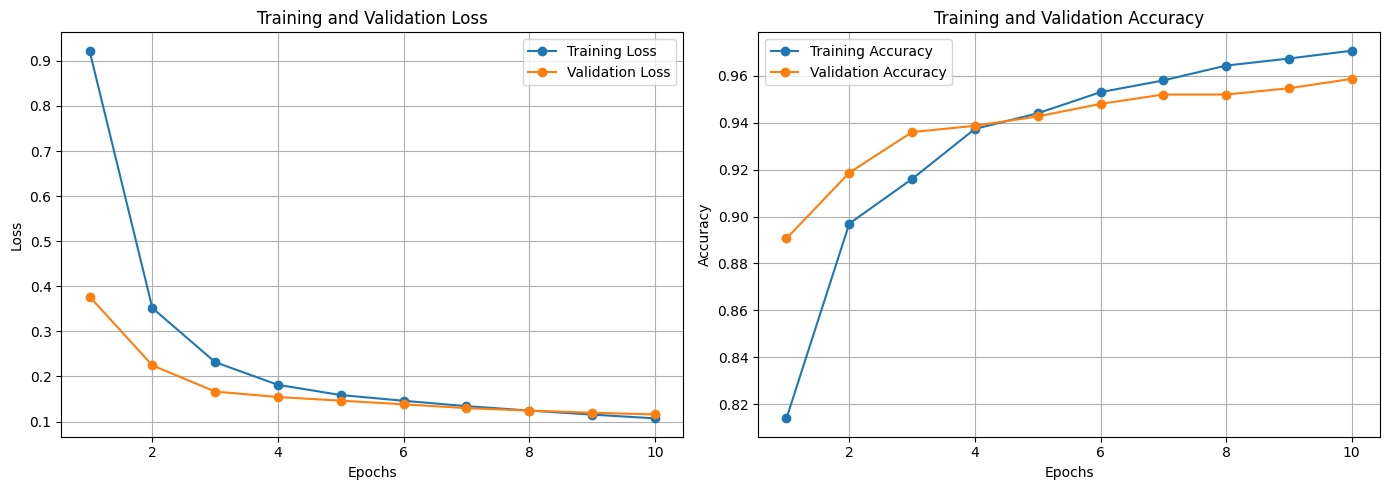

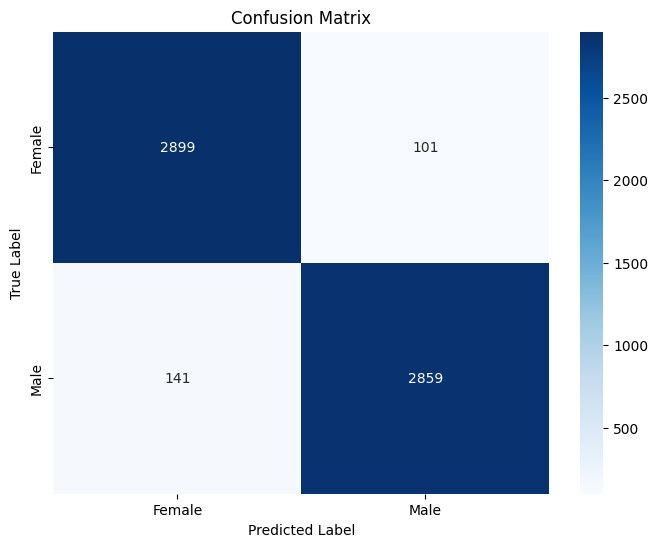

Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.97      0.96      3000
           1       0.97      0.95      0.96      3000

    accuracy                           0.96      6000
   macro avg       0.96      0.96      0.96      6000
weighted avg       0.96      0.96      0.96      6000


Additional Metrics:
Precision: 0.9659
Recall (Sensitivity): 0.9530
F1-Score: 0.9594
Specificity: 0.9663


In [12]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

history_dict = history.history
loss = history_dict['loss']
val_loss = history_dict['val_loss']
accuracy = history_dict['accuracy']
val_accuracy = history_dict['val_accuracy']
epochs = range(1, len(loss) + 1)

plt.figure(figsize=(14, 5))
plt.subplot(1, 2, 1)
plt.plot(epochs, loss, label='Training Loss', marker='o')
plt.plot(epochs, val_loss, label='Validation Loss', marker='o')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid()

plt.subplot(1, 2, 2)
plt.plot(epochs, accuracy, label='Training Accuracy', marker='o')
plt.plot(epochs, val_accuracy, label='Validation Accuracy', marker='o')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid()

plt.tight_layout()
plt.show()

conf_matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Female', 'Male'], yticklabels=['Female', 'Male'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

print("Classification Report:")
print(report)

tn, fp, fn, tp = conf_matrix.ravel()
precision = tp / (tp + fp)
recall = tp / (tp + fn)
f1_score = 2 * (precision * recall) / (precision + recall)
specificity = tn / (tn + fp)
print("\nAdditional Metrics:")
print(f"Precision: {precision:.4f}")
print(f"Recall (Sensitivity): {recall:.4f}")
print(f"F1-Score: {f1_score:.4f}")
print(f"Specificity: {specificity:.4f}")


# Regression Metrics

### Explanation:

1. **Predictions and Actual Values**:
    - The predicted probabilities (`y_prob`) are generated by the model using `model.predict()`, and the actual values (`y_actual`) are taken from the `y_test` set.
    - The predictions are flattened to ensure they match the dimensions of the actual values.

2. **Calculating Regression Metrics**:
    - **Mean Absolute Error (MAE)**: This metric measures the average magnitude of errors in predictions without considering their direction. It is calculated using `mean_absolute_error()`.
    - **Mean Squared Error (MSE)**: This metric measures the average squared difference between predicted and actual values, emphasizing larger errors. It is computed using `mean_squared_error()`.
    - **R² Score**: The coefficient of determination, or R² score, provides an indication of how well the predicted values match the actual values. It is calculated using `r2_score()`.
    - **Pearson Correlation Coefficient**: This metric measures the linear correlation between the actual and predicted values. It is computed using `pearsonr()` from `scipy.stats`.

3. **Printing the Metrics**:
    - The calculated metrics (MAE, MSE, R², and Pearson Correlation) are printed with their respective values for model evaluation.


In [13]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from scipy.stats import pearsonr
import numpy as np

y_prob = model.predict(X_test).flatten()
y_actual = y_test

mae = mean_absolute_error(y_actual, y_prob)

mse = mean_squared_error(y_actual, y_prob)

r2 = r2_score(y_actual, y_prob)

pearson_corr, _ = pearsonr(y_actual, y_prob)

# Print metrics
print("\nAdditional Regression Metrics:")
print(f"Mean Absolute Error (MAE): {mae:.4f}")
print(f"Mean Squared Error (MSE): {mse:.4f}")
print(f"R² Score: {r2:.4f}")
print(f"Pearson Correlation Coefficient: {pearson_corr:.4f}")


188/188 ━━━━━━━━━━━━━━━━━━━━ 6s 32ms/step

Additional Regression Metrics:
Mean Absolute Error (MAE): 0.0741
Mean Squared Error (MSE): 0.0325
R² Score: 0.8700
Pearson Correlation Coefficient: 0.9329
